### Setting Up Environment

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import gseapy
import pandas as pd 
from pathlib import Path
import matplotlib.colors as mcolors
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method
import os
import sys
import hashlib
import colorsys
from graphviz import Digraph
from adjustText import adjust_text
import matplotlib.patheffects as path_effects
import random

sys.path.append('../src/TMEGPT')
from Graph import Node, Graph, Edge
import pickle
from scipy.stats import ttest_ind
import networkx as nx


In [2]:
adata = sc.read_h5ad(filename='../data/processed_data.h5ad')

# Define the old-to-new mapping
rename_dict = {
    'chronic obstructive pulmonary disease': 'COPD',
    'lung adenocarcinoma': 'LUAD',
    'non-small cell lung carcinoma': 'NSCLC',
    'normal': 'normal',
    'squamous cell lung carcinoma': 'LUSC'
}

# Apply the mapping
adata.obs['disease'] = adata.obs['disease'].replace(rename_dict)


### Figure 1 

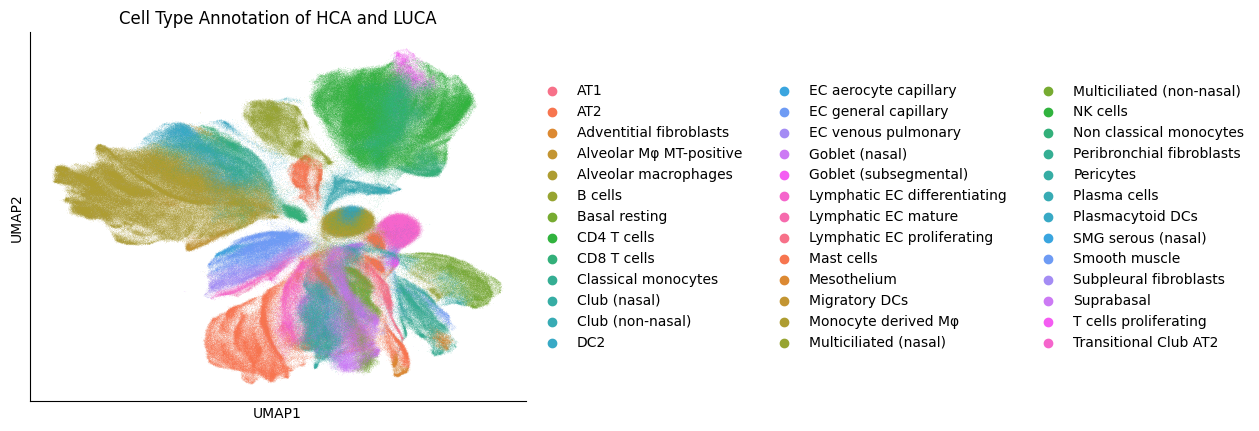

In [3]:
adata.obs['leiden_res_20.00_celltype'] = (
    adata.obs['leiden_res_20.00_celltype']
    .cat.remove_unused_categories()
)

sc.pl.umap(
    adata,
    color='leiden_res_20.00_celltype',
    size=0.2,
    show=False 
)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.tick_params(width=1.5)

title_font = ax.title.get_fontproperties()
ax.set_title('Cell Type Annotation of HCA and LUCA', fontproperties=title_font)

plt.savefig('umap_celltype_annotation.png', dpi=300, bbox_inches='tight')

plt.show()

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score

resolutions = [0.1, 1, 5, 10, 20]

# Randomly sample indices
indices = np.random.choice(len(adata.obsm['X_pca']), size=1000, replace=False)
umap_sample = adata.obsm['X_pca'][indices]

for r in resolutions:
    if r == 'celltypist':
        cluster_col = 'celltypist'
    else:
        # Format numerical resolutions with two decimals: e.g. 4 -> 4.00
        cluster_col = f"leiden_res_{float(r):.2f}_celltype"

    # Get cluster labels for the sampled cells
    cluster_sample = adata.obs[cluster_col].values[indices]

    # Compute silhouette metrics on the subset
    silhouette_vals_sample = silhouette_samples(umap_sample, cluster_sample)
    overall_avg = silhouette_score(umap_sample, cluster_sample)

    # Create a DataFrame and compute averages per cluster
    df = pd.DataFrame({
        'cluster': cluster_sample,
        'silhouette': silhouette_vals_sample
    })
    avg_silhouette_per_cluster = df.groupby('cluster')['silhouette'].mean()

    # Print results
    print(f"Resolution: {cluster_col}")
    print(f"Overall average silhouette: {overall_avg:.4f}")
    print("Average silhouette per cluster:")
    print(avg_silhouette_per_cluster)
    print("-" * 50)


Resolution: leiden_res_0.10_celltype
Overall average silhouette: 0.1069
Average silhouette per cluster:
cluster
AT2                          0.389662
B cells                      0.282436
CD8 T cells                  0.120494
Club (nasal)                -0.045433
EC general capillary         0.238772
Mast cells                   0.193261
Monocyte derived Mφ          0.103279
Multiciliated (non-nasal)    0.420874
Peribronchial fibroblasts    0.121097
Name: silhouette, dtype: float32
--------------------------------------------------
Resolution: leiden_res_1.00_celltype
Overall average silhouette: 0.1060
Average silhouette per cluster:
cluster
AT1                          0.155275
AT2                         -0.072743
Alveolar macrophages         0.188598
B cells                      0.220682
CD4 T cells                  0.130615
CD8 T cells                 -0.040631
Classical monocytes          0.126085
Club (nasal)                 0.073229
DC2                          0.108473
EC gener

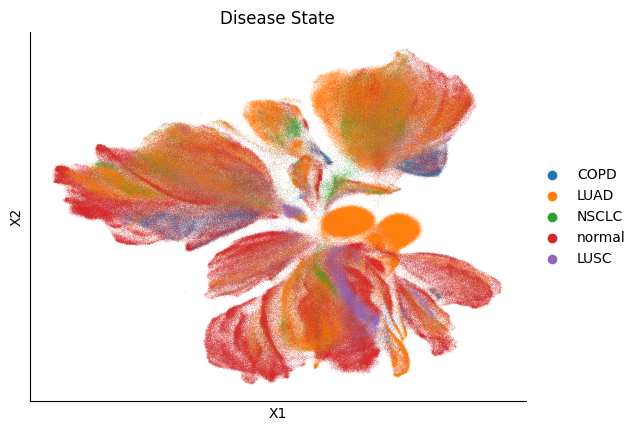

In [5]:
sc.pl.umap(
    adata,
    color='disease',
    size=0.2,
    show=False 
)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('X1')
ax.set_ylabel('X2')

title_font = ax.title.get_fontproperties()
ax.set_title('Disease State', fontproperties=title_font)

plt.savefig('umap_disease_annotation.png', dpi=300, bbox_inches='tight')

plt.show()

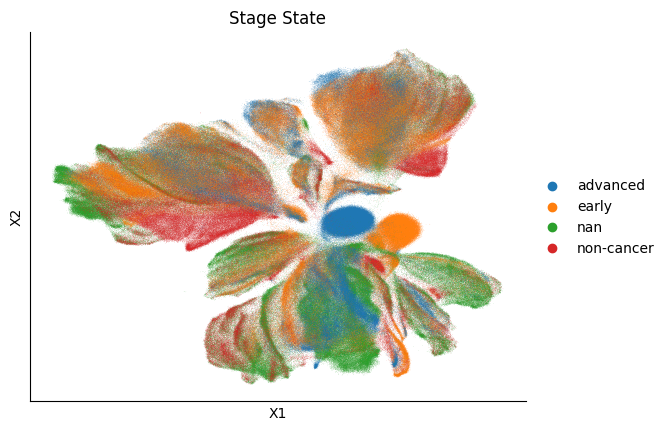

In [6]:
sc.pl.umap(
    adata,
    color='tumor_stage',
    size=0.2,
    show=False 
)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('X1')
ax.set_ylabel('X2')

title_font = ax.title.get_fontproperties()
ax.set_title('Stage State', fontproperties=title_font)

plt.savefig('umap_tumor_stage_annotation.png', dpi=300, bbox_inches='tight')

plt.show()

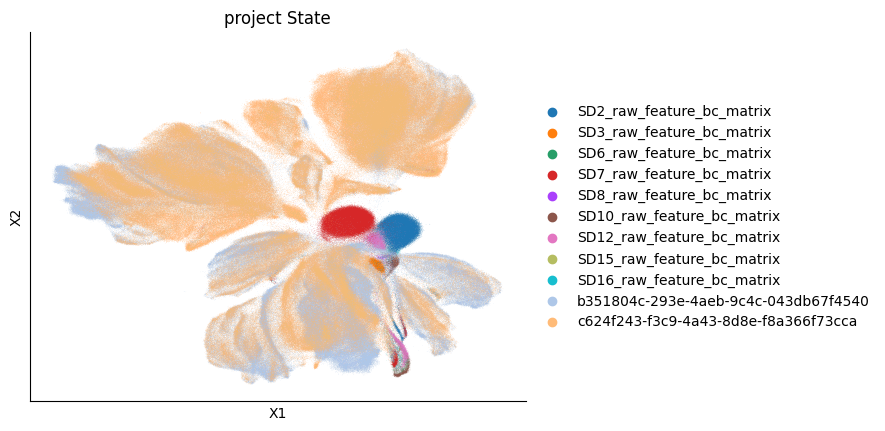

In [7]:
sc.pl.umap(
    adata,
    color='project',
    size=0.2,
    show=False 
)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('X1')
ax.set_ylabel('X2')

title_font = ax.title.get_fontproperties()
ax.set_title('project State', fontproperties=title_font)

plt.savefig('umap_project_annotation.png', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
from matplotlib.colors import LinearSegmentedColormap

cmap_custom = LinearSegmentedColormap.from_list('gray_emerald', ['gray', '#50C878'])

# Randomly select 4 genes that exist in the datasetCD
genes = ['MUC1', 'CD163', 'COL1A2', 'CD3D']

fig, axes = plt.subplots(1, len(genes), figsize=(25, 5))
plt.subplots_adjust(wspace=0.15)

for i, gene in enumerate(genes):
    sc.pl.umap(
        adata,
        color=gene,
        size=0.2,
        sort_order=True,  # This ensures cells with higher expression appear on top
        cmap=cmap_custom,
        ax=axes[i],
        show=False,
        colorbar_loc=None  # No colorbar in the loop
    )
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    if i == 0:
        axes[i].set_ylabel('X2')
    else:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].set_yticks([])

    axes[i].set_xlabel('X1')
    axes[i].set_title(f'{gene} Expression')

    for spine in axes[i].spines.values():
        if spine.get_visible():
            spine.set_linewidth(1.5) 
    
    axes[i].tick_params(width=1.5)

# Add a single colorbar outside the loop
expr = adata[:, genes[0]].X
expr_arr = expr.toarray().flatten() if hasattr(expr, "toarray") else np.array(expr).flatten()

sm = plt.cm.ScalarMappable(cmap=cmap_custom)
sm.set_array(expr_arr)
sm.set_clim(expr_arr.min(), expr_arr.max())

cbar = plt.colorbar(sm, ax=axes, fraction=0.02, pad=0.04)
cbar.set_label('Expression')

plt.savefig('figure-1-E.png', dpi=300, bbox_inches='tight')
plt.close()

In [11]:
from matplotlib.colors import LinearSegmentedColormap

cmap_custom = LinearSegmentedColormap.from_list('gray_emerald', ['gray', '#50C878'])

# Randomly select 4 genes that exist in the datasetCD
genes = ['EPCAM', 'VEGFD', 'CXCR4', 'FOXI1']

fig, axes = plt.subplots(1, len(genes), figsize=(25, 5))
plt.subplots_adjust(wspace=0.15)

for i, gene in enumerate(genes):
    sc.pl.umap(
        adata,
        color=gene,
        size=0.2,
        sort_order=True,  # This ensures cells with higher expression appear on top
        cmap=cmap_custom,
        ax=axes[i],
        show=False,
        colorbar_loc=None  # No colorbar in the loop
    )
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    if i == 0:
        axes[i].set_ylabel('X2')
    else:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].set_yticks([])

    axes[i].set_xlabel('X1')
    axes[i].set_title(f'{gene} Expression')

    for spine in axes[i].spines.values():
        if spine.get_visible():
            spine.set_linewidth(1.5) 
    
    axes[i].tick_params(width=1.5)

# Add a single colorbar outside the loop
expr = adata[:, genes[0]].X
expr_arr = expr.toarray().flatten() if hasattr(expr, "toarray") else np.array(expr).flatten()

sm = plt.cm.ScalarMappable(cmap=cmap_custom)
sm.set_array(expr_arr)
sm.set_clim(expr_arr.min(), expr_arr.max())

cbar = plt.colorbar(sm, ax=axes, fraction=0.02, pad=0.04)
cbar.set_label('Expression')

plt.savefig('supp-figure-1-D.png', dpi=300, bbox_inches='tight')
plt.close()

In [12]:
from matplotlib.colors import LinearSegmentedColormap

cmap_custom = LinearSegmentedColormap.from_list('gray_emerald', ['gray', '#50C878'])

# Randomly select 4 genes that exist in the datasetCD
genes = ['IRF4', 'MAPK1', 'NOTCH2', 'U2AF1']

fig, axes = plt.subplots(1, len(genes), figsize=(25, 5))
plt.subplots_adjust(wspace=0.15)

for i, gene in enumerate(genes):
    sc.pl.umap(
        adata,
        color=gene,
        size=0.2,
        sort_order=True,  # This ensures cells with higher expression appear on top
        cmap=cmap_custom,
        ax=axes[i],
        show=False,
        colorbar_loc=None  # No colorbar in the loop
    )
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    if i == 0:
        axes[i].set_ylabel('X2')
    else:
        axes[i].spines['left'].set_visible(False)
        axes[i].set_ylabel('')
        axes[i].set_yticks([])

    axes[i].set_xlabel('X1')
    axes[i].set_title(f'{gene} Expression')

    for spine in axes[i].spines.values():
        if spine.get_visible():
            spine.set_linewidth(1.5) 
    
    axes[i].tick_params(width=1.5)

# Add a single colorbar outside the loop
expr = adata[:, genes[0]].X
expr_arr = expr.toarray().flatten() if hasattr(expr, "toarray") else np.array(expr).flatten()

sm = plt.cm.ScalarMappable(cmap=cmap_custom)
sm.set_array(expr_arr)
sm.set_clim(expr_arr.min(), expr_arr.max())

cbar = plt.colorbar(sm, ax=axes, fraction=0.02, pad=0.04)
cbar.set_label('Expression')

plt.savefig('supp-figure-1-E.png', dpi=300, bbox_inches='tight')
plt.close()

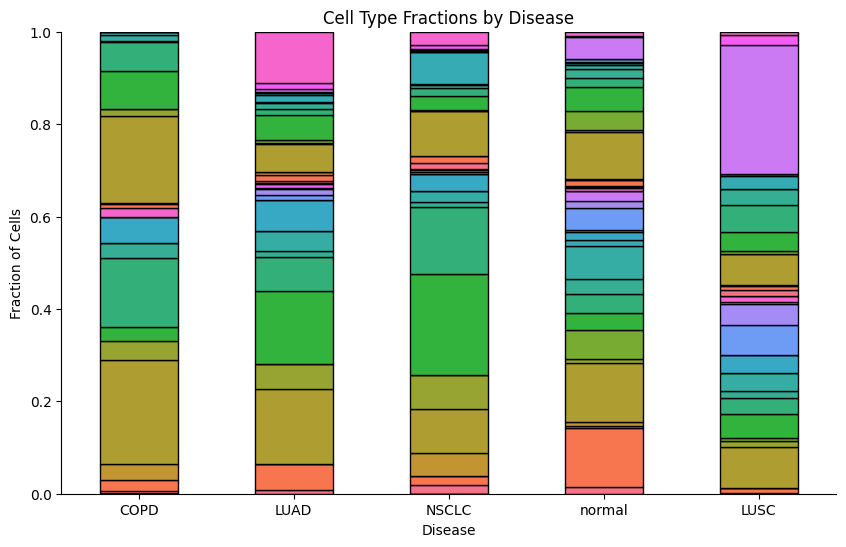

In [25]:
import matplotlib.pyplot as plt

disease_col = 'disease'
celltype_col = 'leiden_res_20.00_celltype'

# Create pivot table of cell counts per disease per cell type
pt = adata.obs.groupby([disease_col, celltype_col]).size().unstack(fill_value=0)

# Create fractions table (each row sums to 1)
pt_frac = pt.div(pt.sum(axis=1), axis=0)

# Get the cell type colors and ensure the columns are in the correct order
celltype_colors = adata.uns[f"{celltype_col}_colors"] 
celltype_categories = adata.obs[celltype_col].cat.categories
pt_frac = pt_frac.reindex(columns=celltype_categories)

# Plot the stacked bar plot
ax = pt_frac.plot(
    kind='bar',
    stacked=True,
    color=celltype_colors,
    edgecolor='black',
    linewidth=1,
    figsize=(10, 6)
)

ax.set_xlabel('Disease')
ax.set_ylabel('Fraction of Cells')
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Cell Type Fractions by Disease')

# Remove the legend entirely
legend = ax.get_legend()
if legend:
    legend.remove()

plt.savefig('barplot_celltype_fractions.png', dpi=300, bbox_inches='tight')
plt.show()


### Figure 2

In [26]:
save_path = 'figure_2A.png'

# your epithelial categories
EPITHELIAL_CATS = [
    'AT2', 'AT1', 'Suprabasal', 'Basal resting',
    'Multiciliated (non-nasal)', 'Goblet (nasal)',
    'Club (nasal)', 'Ciliated (nasal)',
    'Club (non-nasal)', 'Multiciliated (nasal)',
    'Goblet (bronchial)', 'Transitional Club AT2',
    'AT2 proliferating', 'Goblet (subsegmental)'
]

# 1) add “Other” as a valid category on the original column
orig = adata.obs['leiden_res_20.00_celltype'].cat.add_categories(['Other'])

# 2) build the highlight column, mapping everything else to 'Other'
#    then immediately drop any unused categories (so only EPITHELIAL_CATS + 'Other' remain)
adata.obs['highlight'] = (
    orig
      .where(orig.isin(EPITHELIAL_CATS), other='Other')
      .cat
      .remove_unused_categories()
)


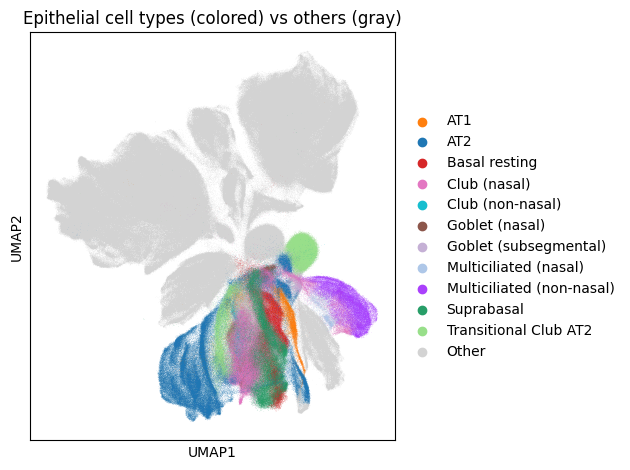

In [27]:
# Prepare color palette
base_pal = sc.pl.palettes.default_20
if len(EPITHELIAL_CATS) > len(base_pal):
    palette_vals = plt.cm.tab20.colors * ((len(EPITHELIAL_CATS) // len(base_pal)) + 1)
else:
    palette_vals = base_pal

palette = {cat: palette_vals[i] for i, cat in enumerate(EPITHELIAL_CATS)}
palette['Other'] = '#d3d3d3'

# Plot UMAP
sc.pl.umap(
    adata,
    color='highlight',
    palette=palette,
    size=0.2,
    legend_loc='right margin',
    title='Epithelial cell types (colored) vs others (gray)',
    show=False
)
plt.tight_layout()

# Ensure the output directory exists, then save
if save_path is None:
    figures_dir = Path.cwd() / 'figures'
    figures_dir.mkdir(parents=True, exist_ok=True)
    save_path = figures_dir / 'figure_2A.png'
else:
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import scanpy as sc

save_path = 'figure_2B.png'

# Subset to epithelial cells
epi = adata[adata.obs['leiden_res_20.00_celltype'].isin(EPITHELIAL_CATS)].copy()

# Custom colormap
cmap_custom = LinearSegmentedColormap.from_list('gray_emerald', ['gray', '#50C878'])

# Marker genes to plot
genes = ['AGER', 'HOPX', 'ABCA3', 'SFTPC', 'MUC1', 'SCGB1A1']

# Create 2×3 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

# Plot each gene UMAP
for i, gene in enumerate(genes):
    ax = axes[i]
    sc.pl.umap(
        epi,
        color=gene,
        size=0.2,
        sort_order=True,
        cmap=cmap_custom,
        ax=ax,
        show=False,
        colorbar_loc=None
    )
    # Tidy axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if i % 3 == 0:
        ax.set_ylabel('X2')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel('')
    ax.set_xlabel('X1')
    ax.set_title(f'{gene} Expression')
    for spine in ax.spines.values():
        if spine.get_visible():
            spine.set_linewidth(1.5)
    ax.tick_params(width=1.5)

# Shared colorbar
expr = epi[:, genes[0]].X
expr_arr = expr.toarray().flatten() if hasattr(expr, 'toarray') else np.array(expr).flatten()
sm = plt.cm.ScalarMappable(cmap=cmap_custom)
sm.set_array(expr_arr)
sm.set_clim(expr_arr.min(), expr_arr.max())
cbar = fig.colorbar(sm, ax=axes, fraction=0.015, pad=0.04)
cbar.set_label('Expression')

# --- Symmetric zoom around the data‐center ---
zoom_frac = 0.8  # keep 80% of the span; tweak between 0 and 1

# grab the UMAP coords
umap = epi.obsm['X_umap']
x, y = umap[:, 0], umap[:, 1]

# compute center and half‐ranges
x_c, y_c = x.mean(), y.mean()
half_x = (x.max() - x.min()) * zoom_frac / 2
half_y = (y.max() - y.min()) * zoom_frac / 2

# apply identical limits to all axes
for ax in axes:
    ax.set_xlim(x_c - half_x, x_c + half_x)
    ax.set_ylim(y_c - half_y, y_c + half_y)

# Save figure
save_path = Path(save_path)
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)

In [29]:
# Your six pathway‐score columns
scores = [
    'REACTOME_SIGNALING_BY_EGFR_IN_CANCER',
    'HALLMARK_G2M_CHECKPOINT',
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
    'HALLMARK_APOPTOSIS',
    'HALLMARK_P53_PATHWAY',
    'HALLMARK_KRAS_SIGNALING_UP'
]

# Custom colormap
cmap_custom = LinearSegmentedColormap.from_list('gray_emerald', ['gray', '#50C878'])

# Compute global vmin/vmax across all six score columns for a shared color‐scale
all_vals = epi.obs[scores].values.flatten()
vmin, vmax = np.nanmin(all_vals), np.nanmax(all_vals)

# Set up 2×3 axes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for i, score in enumerate(scores):
    ax = axes[i]
    sc.pl.umap(
        epi,
        color=score,
        size=0.2,
        sort_order=True,
        cmap=cmap_custom,
        vmin=vmin,
        vmax=vmax,
        ax=ax,
        show=False,
        colorbar_loc=None
    )

    # tidy up the axes
    ax.set_title(score.replace('_', ' '), fontsize=14)
    ax.set_xlabel('X1')
    if i % 3 == 0:
        ax.set_ylabel('X2')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_ylabel('')
    for spine in ('top','right'):
        ax.spines[spine].set_visible(False)
    for spine in ax.spines.values():
        if spine.get_visible():
            spine.set_linewidth(1.5)
    ax.tick_params(width=1.5)

# Single shared colorbar at the bottom
sm = plt.cm.ScalarMappable(cmap=cmap_custom)
sm.set_clim(vmin, vmax)
sm.set_array([])  # dummy
cbar = fig.colorbar(sm, ax=axes, fraction=0.015, pad=0.04)
cbar.set_label('Pathway score', fontsize=12)

# --- Symmetric zoom around the data‐center ---
zoom_frac = 0.8  # keep 80% of the span; tweak between 0 and 1

# grab the UMAP coords
umap = epi.obsm['X_umap']
x, y = umap[:, 0], umap[:, 1]

# compute center and half‐ranges
x_c, y_c = x.mean(), y.mean()
half_x = (x.max() - x.min()) * zoom_frac / 2
half_y = (y.max() - y.min()) * zoom_frac / 2

# apply identical limits to all axes
for ax in axes:
    ax.set_xlim(x_c - half_x, x_c + half_x)
    ax.set_ylim(y_c - half_y, y_c + half_y)

# Save
save_path = Path('figure_2B_2.png')
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)


In [31]:
# compute overall means
kras_mean = adata.obs["HALLMARK_KRAS_SIGNALING_UP"].mean()
egfr_mean = adata.obs["REACTOME_SIGNALING_BY_EGFR_IN_CANCER"].mean()

# annotate boolean flags
adata.obs["KRAS_high"] = adata.obs["HALLMARK_KRAS_SIGNALING_UP"] > kras_mean
adata.obs["EGFR_high"] = adata.obs["REACTOME_SIGNALING_BY_EGFR_IN_CANCER"] > egfr_mean

# sanity‐check
print(f"HALLMARK_KRAS_SIGNALING_UP mean = {kras_mean:.3f}")
print(adata.obs["KRAS_high"].value_counts())
print(f"REACTOME_SIGNALING_BY_EGFR_IN_CANCER mean = {egfr_mean:.3f}")
print(adata.obs["EGFR_high"].value_counts())


HALLMARK_KRAS_SIGNALING_UP mean = 0.065
KRAS_high
False    898611
True     741550
Name: count, dtype: int64
REACTOME_SIGNALING_BY_EGFR_IN_CANCER mean = 0.398
EGFR_high
True     873375
False    766786
Name: count, dtype: int64


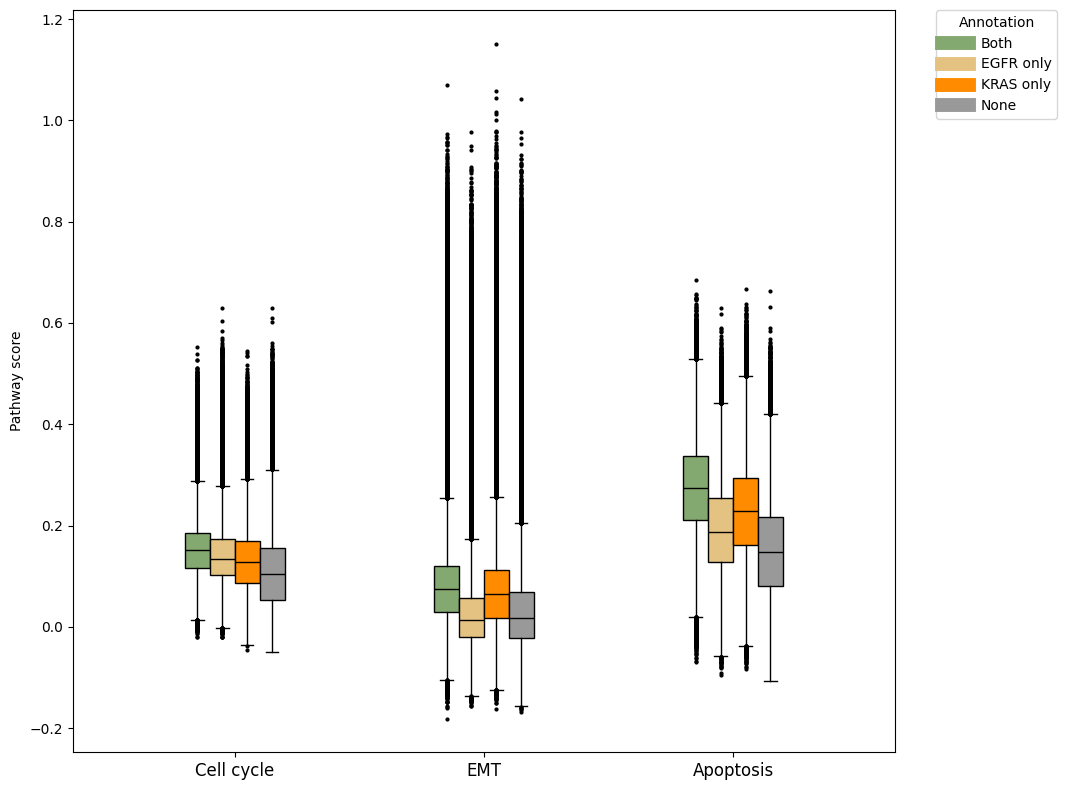

In [32]:
cols   = [
    'REACTOME_CELL_CYCLE',
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
    'HALLMARK_APOPTOSIS'
]
labels = ['Cell cycle', 'EMT', 'Apoptosis']

# 2) the four annotation categories + colors
categories = [
    'Both',        # KRAS_high & EGFR_high
    'EGFR only',   # ~KRAS_high & EGFR_high
    'KRAS only',   # KRAS_high & ~EGFR_high
    'None'         # neither
]
colors = {
    'Both':      '#84A970',
    'EGFR only': '#E4C282',
    'KRAS only': '#FF8C00',
    'None':      '#999999'
}

# 3) layout parameters
n_groups  = len(cols)
n_cats    = len(categories)
width     = 0.1
grp_space = width * n_cats
offsets   = np.linspace(
    -grp_space/2 + width/2,
     grp_space/2 - width/2,
    n_cats
)

# 4) prep figure
fig, ax = plt.subplots(figsize=(12, 8))

# 5) for each annotation category, collect data & plot
for i, cat in enumerate(categories):
    if cat == 'Both':
        mask = adata.obs['KRAS_high'] & adata.obs['EGFR_high']
    elif cat == 'EGFR only':
        mask = ~adata.obs['KRAS_high'] & adata.obs['EGFR_high']
    elif cat == 'KRAS only':
        mask = adata.obs['KRAS_high'] & ~adata.obs['EGFR_high']
    else:  # None
        mask = ~adata.obs['KRAS_high'] & ~adata.obs['EGFR_high']

    # gather arrays for each pathway
    data = [
        adata.obs.loc[mask, col].dropna().values
        for col in cols
    ]
    positions = np.arange(n_groups) + offsets[i]

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=width,
        patch_artist=True,
        flierprops=dict(marker='o', markersize=2,
                        markerfacecolor='black',
                        markeredgecolor='black')
    )
    # color boxes
    for box in bp['boxes']:
        box.set_facecolor(colors[cat])
        box.set_edgecolor('black')
    for elt in bp['whiskers'] + bp['caps'] + bp['medians']:
        elt.set_color('black')

# 6) x‐axis ticks & labels
ax.set_xticks(np.arange(n_groups))
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_ylabel('Pathway score')

# 7) legend
handles = [
    plt.Line2D([0], [0], color=colors[c], lw=10)
    for c in categories
]
ax.legend(
    handles, categories, title='Annotation',
    bbox_to_anchor=(1.05, 1), loc='upper left',
    borderaxespad=0
)

# 8) finalize
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.savefig('Fig-2G.png', dpi=300, bbox_inches='tight')

plt.show()